In [9]:
# ===== 0. Save Images as HDF5
import os
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
import h5py
import random

# Utils
start_time = time.time()
def watch_restart():
    global start_time
    start_time = time.time()
def watch_print(title):
    global start_time
    print(title, (time.time() - start_time), 'seconds')

DATA_DIR = 'dataset_raw'
DATASET_FILE = 'dataset.h5'
DATASET_FILE_MEDIUM = 'dataset_medium.h5'
DATASET_FILE_MEDIUM_SIZE = 10000
DATASET_FILE_MINI = 'dataset_mini.h5'
DATASET_FILE_MINI_SIZE = 1000
DATASET_IMAGES = 'images'
DATASET_LABELS = 'labels'
IMAGE_DIMENSION = 400
LABEL_CLASS = { 'NORMAL': 0, 'CNV': 1, 'DME': 2, 'DRUSEN': 3 }

# 0.1. Get Image Paths and Labels
image_paths = []
image_labels = []
for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        path = "{0}/{1}/{2}/{3}".format(
            DATA_DIR,
            os.path.split(os.path.dirname(root))[1], 
            os.path.split(root)[1], 
            file)
        label = LABEL_CLASS[os.path.split(root)[1]]
        image_paths.append(path)
        image_labels.append(label)

watch_print('Get Images Paths and Labels')

Get Images Paths and Labels 0.5640418529510498 seconds


In [10]:
# 0.2. Save Images as HDF5 to read faster for later use (Commented since file only needs to be created only once)
watch_restart()

def create_hdf5(image_paths,
                image_labels,
                image_dimension,
                dataset_file_name,
                dataset_file_size,
                dataset_image_name,
                dataset_label_name):
    with h5py.File(dataset_file_name, 'w') as hf:
        labels = []
        # Create Image Dataset
        hf.create_dataset(dataset_image_name, (dataset_file_size, image_dimension, image_dimension), np.int8)
        # Get random indexes to shuffle
        random_indexes = random.sample(range(0, len(image_paths)), dataset_file_size)
        for index, random_index in enumerate(random_indexes):
            # Read Image
            image = cv2.imread(image_paths[random_index], cv2.IMREAD_GRAYSCALE)
            # Resize to a smaller image to compute faster
            image = cv2.resize(image, (image_dimension, image_dimension), interpolation=cv2.INTER_LINEAR)
            # Append Image to HDF5 file
            hf[dataset_image_name][index, ...] = image[None]
            labels.append(image_labels[random_index])
        # Create Label Dataset
        hf.create_dataset(dataset_label_name, (len(labels), ), np.int8)
        hf[dataset_label_name][...] = labels
        
# create_hdf5(image_paths,
#             image_labels,
#             IMAGE_DIMENSION,
#             DATASET_FILE_MINI,
#             DATASET_FILE_MINI_SIZE,
#             DATASET_IMAGES,
#             DATASET_LABELS)
# create_hdf5(image_paths,
#             image_labels,
#             IMAGE_DIMENSION,
#             DATASET_FILE_MEDIUM,
#             DATASET_FILE_MEDIUM_SIZE,
#             DATASET_IMAGES,
#             DATASET_LABELS)
# create_hdf5(image_paths,
#             image_labels,
#             IMAGE_DIMENSION,
#             DATASET_FILE,
#             len(image_paths),
#             DATASET_IMAGES,
#             DATASET_LABELS)

watch_print('Save Images as HDF5')

Save Images as HDF5 427.5575215816498 seconds


In [19]:
watch_restart()

# ===== 1. Read Images from HDF5

# Configure Here for different sizes
file_name = DATASET_FILE     
file_size = len(image_paths)

hf = h5py.File(file_name, 'r')
images = np.array(hf[DATASET_IMAGES]).astype('uint8')
labels = np.array(hf[DATASET_LABELS]).astype('uint8')

watch_print('Read Images from HDF5')

Read Images from HDF5 20.226651191711426 seconds


<class 'numpy.ndarray'>
(84484, 400, 400)
Transformations 275.3542068004608 seconds


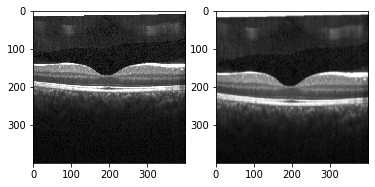

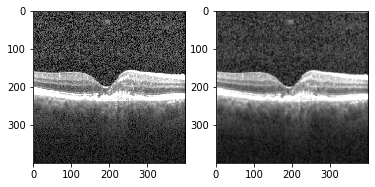

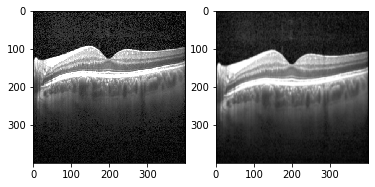

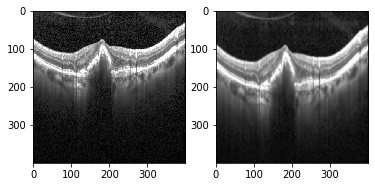

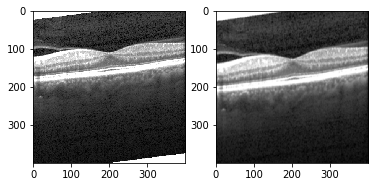

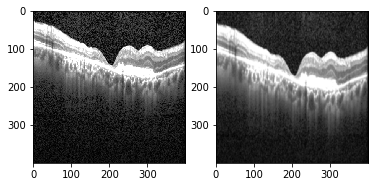

In [20]:
watch_restart()

# ===== 2. Do Transformations and Save CLEAN images

print(type(images))
print(images.shape)

with h5py.File('clean_{0}'.format(file_name), 'w') as clean_hf:
    # Create Image Dataset
    clean_hf.create_dataset(DATASET_IMAGES, (file_size, IMAGE_DIMENSION, IMAGE_DIMENSION), np.int8)
    # Create Label Dataset
    clean_hf.create_dataset(DATASET_LABELS, (file_size, ), np.int8)
    clean_hf[DATASET_LABELS][...] = labels
    
    for index, image in enumerate(images):

        # 2.1. Normalize image
        image_normalized = cv2.normalize(image, 
                                         None, 
                                         alpha=0, 
                                         beta=255, 
                                         norm_type=cv2.NORM_MINMAX, 
                                         dtype=cv2.CV_32F)

        # 2.2.1 Remove noise with Gaussian blur
        image_blurred = cv2.GaussianBlur(image_normalized, (5, 5), 0)
        # 2.2.2 Remove noise with Median Blur (Alternative) 
        # image_blurred = cv2.medianBlur(image_normalized, 5)

        # 2.3. Center Align vertically (find center, crop, and resize)
        # Convert to binary
        ret, image_binary = cv2.threshold(image_blurred, 95, 255, 0)
        # Get the moment (weighted average of pixels) to calculate center coordinates
        moment = cv2.moments(image_binary)
        center_x = int(moment["m10"] / moment["m00"])
        center_y = int(moment["m01"] / moment["m00"])
        # Crop
        y_diff = IMAGE_DIMENSION / 2 - center_y
        y_start = 0
        y_end = IMAGE_DIMENSION 
        if y_diff > 0:
            y_end = int(IMAGE_DIMENSION - abs(y_diff))
        elif y_diff < 0:
            y_start = int(abs(y_diff))
        image_cropped = image_blurred[y_start:y_end, 0:IMAGE_DIMENSION]
        # Resize
        image_centered = cv2.resize(image_cropped, (IMAGE_DIMENSION, IMAGE_DIMENSION), interpolation=cv2.INTER_LINEAR)

        # 2.4. Rotate Skew (Comment out to test out performance on model without it first)
        # # Convert to binary
        # ret, image_binary = cv2.threshold(image_centered, 95, 255, 0)
        # # Get coordinates and angle
        # coords = np.column_stack(np.where(image_binary > 0))
        # angle = cv2.minAreaRect(coords)[-1]
        # angle = -(90 + angle) if angle < -45 else -angle
        # # Get rotation matrix
        # M = cv2.getRotationMatrix2D((IMAGE_DIMENSION//2, IMAGE_DIM//2), angle, 1.0)
        # image_rotated = cv2.warpAffine(image_centered, 
        #                                M, 
        #                                (IMAGE_DIMENSION, IMAGE_DIMENSION), 
        #                                flags=cv2.INTER_CUBIC, 
        #                                borderMode=cv2.BORDER_REPLICATE)

        # Append CLEAN Image to HDF5 file
        clean_hf[DATASET_IMAGES][index, ...] = image_centered[None]
        
        # Show sample images
        if index <= 5:
            f, axarr = plt.subplots(1, 2)
            axarr[0].imshow(image, cmap='gray') # Original 
            axarr[1].imshow(image_centered, cmap='gray') # Transformed

hf.close()
watch_print('Transformations')

In [21]:
watch_restart()

# ===== 3. Read CLEAN Images from HDF5

clean_hf = h5py.File('clean_{0}'.format(file_name), 'r')
images_clean = np.array(clean_hf[DATASET_IMAGES]).astype('uint8')
labels_clean = np.array(clean_hf[DATASET_LABELS]).astype('uint8')

watch_print('Read CLEAN Images from HDF5')

Read CLEAN Images from HDF5 20.526535511016846 seconds


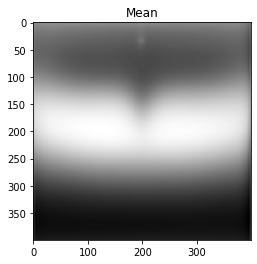

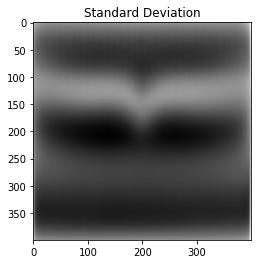

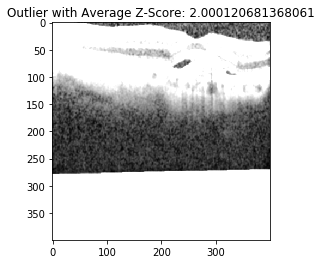

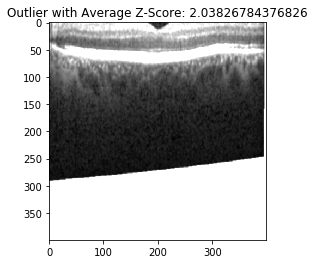

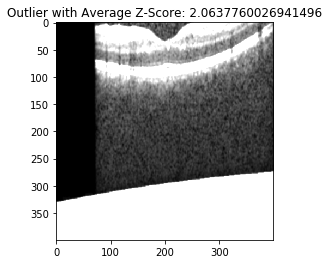

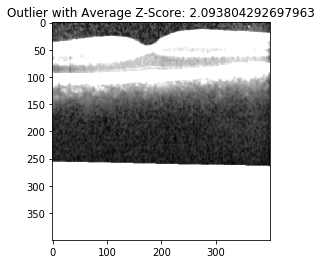

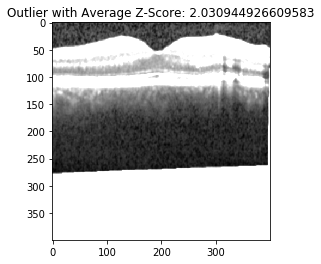

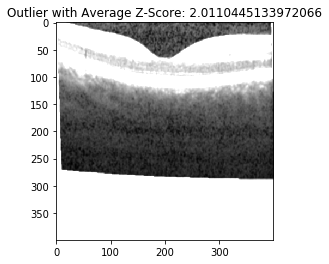

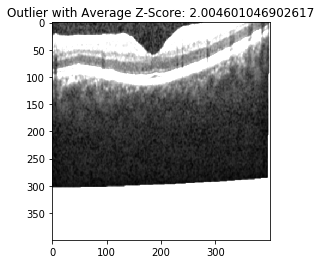

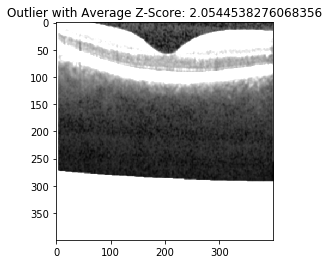

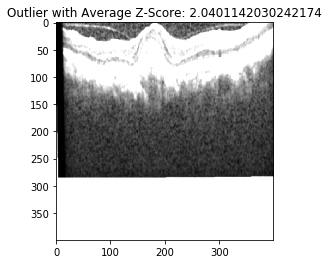

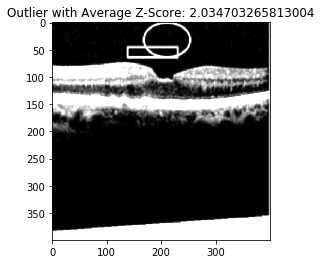

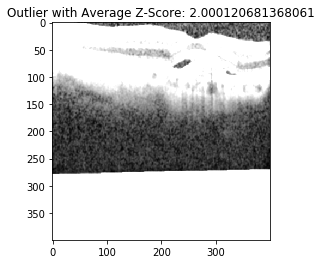

EXPLORATION 107.59414649009705 seconds


In [22]:
watch_restart()

# ===== 4. Explore the Mean, Standard Deviation, and Z-Scores

# 4.1. Get the Mean Image
image_sum_for_mean = np.zeros(shape=(IMAGE_DIMENSION, IMAGE_DIMENSION))
for image in images_clean:
    image_sum_for_mean += image
image_mean = image_sum_for_mean/len(images)
# General structure.
plt.title('Mean')
plt.imshow(image_mean, cmap='gray')
plt.show()

# 4.2. Get the Standard Deviation Image
image_sum_for_std = np.zeros(shape=(IMAGE_DIMENSION, IMAGE_DIMENSION))
for image in images_clean:
    image_sum_for_std += (image - image_mean) ** 2
image_std = (image_sum_for_std/len(images)) ** 0.5
plt.title('Standard Deviation')
plt.imshow(image_std, cmap='gray')
plt.show()

# 4.3. Get Z-Score and Find Outliers
threshold = 2
for image in images_clean:
    z_score = np.abs((image - image_mean) / image_std)
    z_score_avg = np.sum(z_score) / IMAGE_DIMENSION / IMAGE_DIMENSION
    if z_score_avg > threshold:
        plt.title('Outlier with Average Z-Score: {0}'.format(z_score_avg))
        plt.imshow(image, cmap='gray')
        plt.show()
    
clean_hf.close()
watch_print('EXPLORATION')